In [1]:
import findspark
findspark.init('C:\opt\spark') 
# import necessary packages
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [2]:

sc = SparkContext()
# we initiate the StreamingContext with 10 second batch interval. #next we initiate our sqlcontext
ssc = StreamingContext(sc, 10)
sqlContext = SQLContext(sc)

In [3]:

# initiate streaming text from a TCP (socket) source:
socket_stream = ssc.socketTextStream("127.0.0.1", 5555)
# lines of tweets with socket_stream window of size 60, or 60 #seconds windows of time
lines = socket_stream.window(60)

In [4]:
from collections import namedtuple

fields = ("hashtag", "count" )
Tweet = namedtuple( 'Tweet', fields )

fields2 = ("text", "count")
Sentiment = namedtuple('Sentiment', fields2)


In [5]:
# here we apply different operations on the tweets and save them to #a temporary sql table
( lines.flatMap( lambda text: text.split( "b'" ) ) #Splits to a list
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) 
 # Stores in a Tweet Object
  .map( lambda rec: Sentiment( rec[0], rec[1] ) )
 # Sorts Them in a dataframe
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") )
 # Registers only top 10 hashtags to a table.
  .limit(10).registerTempTable("Sentiment") ) )

In [6]:
# here we apply different operations on the tweets and save them to #a temporary sql table
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  # Checks for    hashtag calls  
  .filter( lambda word: word.lower().startswith("#") ) 
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) 
 # Stores in a Tweet Object
  .map( lambda rec: Tweet( rec[0], rec[1] ) )
 # Sorts Them in a dataframe
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") )
 # Registers only top 10 hashtags to a table.
  .limit(10).registerTempTable("tweets") ) )

In [7]:

  # start streaming and wait couple of minutes to get enought tweets
ssc.start()


In [8]:

# import libraries to visualize the results
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
from textblob import TextBlob


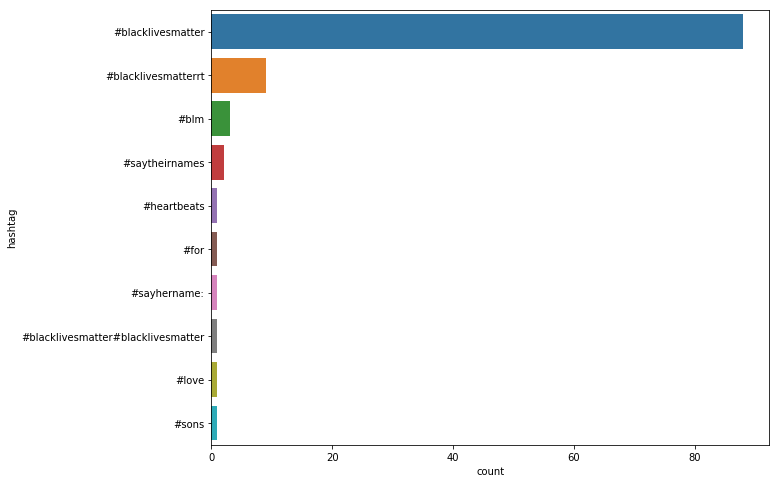

                                                text
0                                                   
1  dozens…rt @joshuapotash: i don't know why thes...
2                                                  .
3  dozens…rt @baddify: say their names and know t...
4                                 #blacklivesmatter 
5                                            anyone?
6                   oakland california last 24 hours
7                                                   
8  #blacklivesmatter (illustrations by me) https:...
9                                #therevolutionisnow
1
Sentiment(polarity=0.0, subjectivity=0.0)
Sentiment(polarity=0.0, subjectivity=0.0)
Sentiment(polarity=0.0, subjectivity=0.0)


In [14]:
#matplotlib inline
count = 0
while count < 1:
    
    time.sleep(5)
    # top hashtags:
    top_10_tags = sqlContext.sql( 'Select hashtag, count from tweets' )
    top_10_df = top_10_tags.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="hashtag", data=top_10_df)
    plt.show()
    #sentiment analysis:
    top_10_senti = sqlContext.sql( 'Select text from Sentiment' )
    top_10_s = top_10_senti.toPandas()
    print(top_10_s)
    count = count + 1
    print(count)
    # Schleife über alle texte, die in top_10_s gespeichert sind, und davon jeweils die sentiment analysis
    n = 3
    s = 0
    i = 1
    while i <= n:
        s = s + i
        opinion = TextBlob(top_10_s["text"][i])
        print(opinion.sentiment)
        i = i + 1


In [10]:
print(top_10_s)

NameError: name 'top_10_s' is not defined

In [12]:
top_10_senti = sqlContext.sql( 'Select text from sentiment' )
top_10_s = top_10_senti.toPandas()

In [15]:
top_10_s

,text
0,
1,dozens…rt @joshuapotash: i don't know why thes...
2,.
3,dozens…rt @baddify: say their names and know t...
4,#blacklivesmatter
5,anyone?
6,oakland california last 24 hours
7,
8,#blacklivesmatter (illustrations by me) https:...
9,#therevolutionisnow


In [21]:
ssc.stop()